#### Predicting Hurricane Trajectories in 24-hour increments
This project will use time-series machine learning models to predict hurricane trajectories over a 24-hour span. First we'll import some stuff.
Time_Series_Pytorch is a library consisting of custom classes that variously use Ridge regression, Pytorch RNN Encoder-Decoder networks, and Pytorch LSTM Encoder-Decoder networks to train, predict, cross-validate, and plot predictions/targets. 

In [1]:
import sys, importlib, Time_Series_PyTorch
import torch, random, numpy, scipy, pandas, matplotlib, statsmodels, random, datetime
importlib.reload(Time_Series_PyTorch) 
from Time_Series_PyTorch import * 
from statsmodels.graphics.tsaplots   import plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss  
torch.manual_seed(1)
random.seed(1) 
numpy.random.seed(1) 

#### Uploading and Cleaning the Hurricane Dataset
Going to upload a hurricane dataset taken from https://www.ncei.noaa.gov/products/international-best-track-archive. It consists of the hurricane ID (SID), time-stamps,  latitude, longitude, basin, and subbasin of hundreds of hurricanes tracked from 1980 to present. There are many more columns of data than these, but these other columns are much less consistently tracked. I only included a subset of columns in the Hurricane Data.csv file.

In [2]:
df_HUR = pandas.read_csv("Hurricane Data.csv", keep_default_na = False)
df_HUR = df_HUR.drop(0, axis=0)

C:\Users\atdou\AppData\Local\Temp\ipykernel_3076\233214603.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_HUR = pandas.read_csv("Hurricane Data.csv", keep_default_na = False)


SID is the unique ID of each hurricane. BASIN and SUBBASIN specify where on Earth the hurricane occurs. I'm going to specifically focus on North Atlantic hurricanes. ISO_TIME is a column consisting of times associated with the latitude and longitude measurements in the LAT and LON columns. I'll convert that to date_time and rename the column TIME.

In [3]:
df_HUR = df_HUR[["SID", "BASIN", "SUBBASIN", "ISO_TIME", "LAT", "LON"]]
df_HUR = df_HUR.astype({"SID":str, "BASIN":str, "SUBBASIN":str, "LAT":float, "LON":float})
df_HUR["TIME"] = pandas.to_datetime(df_HUR["ISO_TIME"])
df_HUR.drop("ISO_TIME", axis=1, inplace=True)
df_NA = df_HUR[df_HUR["BASIN"] == "NA"]
df_NA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40593 entries, 2746 to 300565
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SID       40593 non-null  object        
 1   BASIN     40593 non-null  object        
 2   SUBBASIN  40593 non-null  object        
 3   LAT       40593 non-null  float64       
 4   LON       40593 non-null  float64       
 5   TIME      40593 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.2+ MB


In order to apply time-series models, we need a consistent time interval between time-stamps. So I'll look at the delta TIME values for each hurricane. We have to group them by SID, and find the difference in successive time values.

In [4]:
def delta(x):                                                                                # looks at unique delta TIMES per SID
    return x.diff().dropna().unique()
def delta_checker(x):                                                                        # Isolates the ones with only 3 hour delta TIME
    diffs = x.diff().dropna().unique()
    return len(diffs) == 1 and diffs[0] == datetime.timedelta(hours=3)
def delta_checker_lte3(x):                                                                   # Isolates the ones with <= 3 hour delta TIME
    diffs = x.diff().dropna().unique()
    tv = 1
    for elem in diffs:
        tv*=(elem <= datetime.timedelta(hours=3))
    return bool(tv)
SID_uniquetimedeltas = df_NA.groupby("SID")["TIME"].apply(lambda x: delta(x)) 
print("Sum of unique TIME deltas per hurricane: " + str(len(SID_uniquetimedeltas))) 
SID_time3hmask = df_NA.groupby("SID")["TIME"].apply(lambda x: delta_checker(x))  
print("Sum of unique TIME deltas per hurricane equal to 3 hours: " + str(len(SID_uniquetimedeltas[SID_time3hmask])))
SID_timelte3hmask = df_NA.groupby("SID")["TIME"].apply(lambda x: delta_checker_lte3(x)) 
print("Sum of unique TIME deltas per hurricane <= 3 hours: " + str(len(SID_uniquetimedeltas[SID_timelte3hmask]))   )                      

Sum of unique TIME deltas per hurricane: 733
Sum of unique TIME deltas per hurricane equal to 3 hours: 496
Sum of unique TIME deltas per hurricane <= 3 hours: 733


So TIME column has time intervals of mainly three hours. It might be - hope so - that times at three hour intervals are always present at least, and that some hurricanes just have more frequent time sampling in addition to this. If so, then I'll just delete the times not at three hour intervals. 

In [5]:
def filter_every_3_hours(df):
    keep_indices = []
    for sid, group in df.groupby('SID'):
        group = group.sort_index() 
        start_time = group['TIME'].iloc[0]
        time_diffs = (group['TIME'] - start_time).dt.total_seconds()/3600
        mask = (time_diffs % 3 == 0)
        keep_indices.extend(group[mask].index)
    return df.loc[keep_indices].sort_index()
df_NA = filter_every_3_hours(df_NA)

Now let's make sure that the successive time differences are all still 3 hours, not 6 hours or some other multiple of 3. It looks like there are no rows separated by anything but 3 hours. So we still have all of our hurricanes.

In [6]:
SID_time3hmask = df_NA.groupby("SID")["TIME"].apply(lambda x: delta_checker(x))
print("Number of time intervals not equal to 3 hours is: " + str(len(SID_uniquetimedeltas[~SID_time3hmask])))

Number of time intervals not equal to 3 hours is: 0


Also, going to drop the BASIN and SUBBASIN columns. Their information should be implicit within the LAT and LON columns. So what does df_NA look like now? 

In [7]:
df_NA.drop(["BASIN", "SUBBASIN"], axis = 1, inplace = True)
df_NA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40179 entries, 2746 to 300565
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SID     40179 non-null  object        
 1   LAT     40179 non-null  float64       
 2   LON     40179 non-null  float64       
 3   TIME    40179 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.5+ MB


#### Picking out training and testing set
Now I'm just going to plot a bunch of hurricanes and look for some that hit the Gulf states and some that don't hit land at all; I'll pick three of these to be test hurricanes and make a dictionary out of them. SID will be the key and the dataframe of features will be the value. A better analysis would randomly choose these test hurricanes (and choose more than three) but I'm partly going for aesthetics here; I don't want to fill up the plots below with hurricanes. The unchosen hurricanes will be training hurricanes, and I'll make a dictionary out of them too.

In [8]:
hurrs = {}
for sid, group in df_NA.groupby("SID"):
    hurrs[sid] = group
    hurrs[sid].drop("SID", axis=1, inplace = True)

#sample = list(paths.keys())
#SID_test = [sample[31], sample[139], sample[281], sample[319], sample[413], sample[544], sample[687]]
#SID_test = ["1981250N15306", "1989254N13340", "2000260N15308", "2003188N11307", "2008229N18293", "2016273N13300", "2023292N13309"]
SID_test = ["2003188N11307", "2008229N18293", "2000260N15308"]
hurrs_test = {sid: hurrs[sid] for sid in SID_test}

SID_train = [sid for sid in hurrs.keys() if sid not in SID_test]
hurrs_train = {sid: hurrs[sid] for sid in SID_train}

Now plotting the test hurricanes.

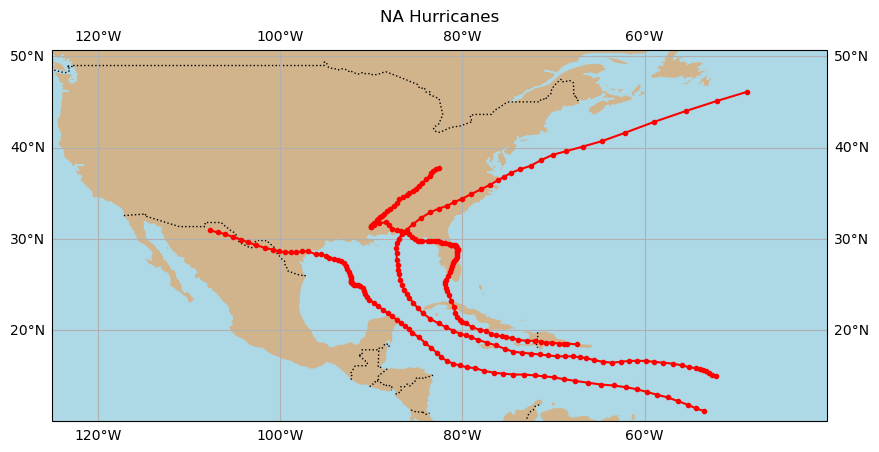

In [9]:
def plot_test_hurricanes(axes):
    axes.set_extent([-125, -40, 10, 42]) 
    axes.add_feature(cfeature.LAND, color = "tan") 
    axes.add_feature(cfeature.OCEAN, color = "lightblue") 
    axes.add_feature(cfeature.BORDERS, linestyle = ":") 
    axes.gridlines(draw_labels = True) 
    for sid, df in hurrs_test.items():
        axes.plot(df["LON"], df["LAT"], color = "red", marker = ".", transform=ccrs.PlateCarree())
    pyplot.title("NA Hurricanes")

fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

#### Applying ML models to the data to predict the hurricane trajectory over the next 24 hours.
Before we proceed, I'll restrict the features of the training and testing dataframes to LON and LAT. I'm going to make predictions in 8 time-step increments (24 hours), starting from the 8th time-step (if we need more than the previous 8 time-steps of the hurricane to make a prediction, then we'll have to adjust the starting point accordingly). For aesthetics' sake, I'm going to clip off the ends of the test paths to make them divisible by 8, so that there is a test data point for every prediction.

In [10]:
y_seq_length = 8      

for sid, df in hurrs_train.items():  
    hurrs_train[sid] = hurrs_train[sid][["LON", "LAT"]]
    
for sid, df in hurrs_test.items():  
    hurrs_test[sid] = hurrs_test[sid][["LON", "LAT"]]
    last_index = int(y_seq_length*numpy.floor(len(hurrs_test[sid])/y_seq_length))
    hurrs_test[sid] = hurrs_test[sid].iloc[0:last_index]

Now let's apply an ML model. The **RE_Vector_Forecaster** takes p sequential vector terms $(x_{n-p+1}, y_{n-p+1}), (x_{n-p+2}, y_{n-p+2}), ..., (x_n, y_n)$, as well as a constant vector $(1,0)$, say, and predicts the next q vector terms $(x_{n+1}, y_{n+1}), ..., (x_{n+q}, y_{n+q})$ at once via multiple linear regression. I'll fit all the training data to the model and use it to predict (in black) the paths of the three test hurricanes. X_seq_length = p is the number of previous terms in the series to regress on. This can be changed, but X_seq_length = 4 seems to be the best. alpha is the Ridge regression parameter; alpha = 0 seems to give the best fit. On the graph we print the average mean square error for the three hurricanes. The error is in units of degrees longitude/latitude. The fit is decent. A linear model should capture the effects of the Coriolis force at least. 

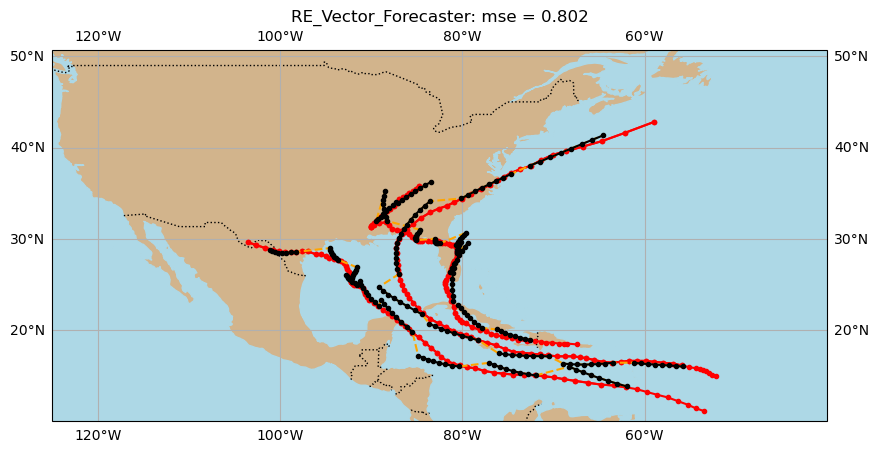

In [11]:
"""
plotting test hurricanes
"""
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

"""
X_seq_length = number of time steps, p, to train on, and y_seq_length = number of time steps q, to predict.
creating datafarme with X_seq_length terms in X_train and y_seq_length terms in y_train. 
adding a column of constant (0,1) vectors to X_train to allow for an intercept.
"""
X_seq_length = 4
df_train = create_dataframe(X_seq_length, y_seq_length)     
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_constant((0,1))                             

"""
fitting training data to a multivariate linear Ridge regression model with specified alpha and predicting both components (LON,LAT), i.e., 
pred_cols = (0,1) in the sequence.  
"""
tsf_rev = RE_Vector_Forecaster(X_seq_length, y_seq_length, alpha = 0)   
tsf_rev.fit(X_train = df_train.X, y_train = df_train.y, pred_cols = [0,1])
tsf_revs = RES_Vector_Forecaster(X_seq_length, y_seq_length, coefs = tsf_rev.model.coef_, intercept = tsf_rev.model.intercept_)

"""
now doing same for test hurricanes.  using the fit model above to predict the test hurricanes path in y_seq_length = 8 time-step segments, 
and plot both the actual and predicted paths. finally, also adding up the total mean square error.
"""
tsf_revs_mse = 0
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(df["LON"], df["LAT"])
    df_test.insert_constant((0,1))
    tsf_revs.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_revs_mse += tsf_revs.cv_results["mse_fold"].mean()   
    tsf_revs.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("RE_Vector_Forecaster: mse = {:.3f}".format(tsf_revs_mse/3))
pyplot.show()

The next model we'll use is similar. The **DE_Vector_Forecaster** takes p sequential terms $(x_{n-p+1}, y_{n-p+1}), (x_{n-p+2}, y_{n-p+2}), ..., (x_n, y_n)$, as well as a constant $(1,0)$, say, and predicts the next term, $(x_{n+1}, y_{n+1}),$ using linear regression. Then it predicts the next q-1 terms terms $(x_{n+2}, y_{n+2}), ..., (x_{n+q}, y_{n+q})$ recursively using the linear regression model determined in the previous step. As before X_seq_length = 5 seems to work best, and this time, the best Ridge regression parameter seems to be alpha = 10. Apparently the recursive approach is a liiiittle better, according to the mse. 

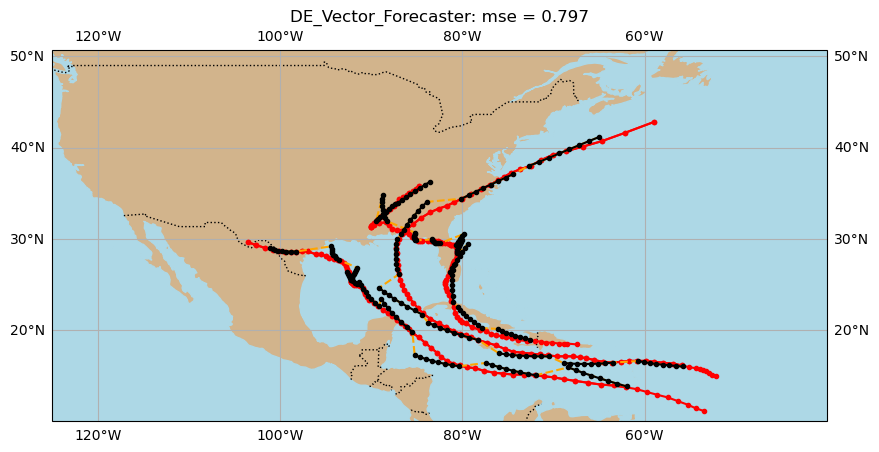

In [12]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 5
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_constant((0,1))

tsf_dev = DE_Vector_Forecaster(X_seq_length, y_seq_length, alpha = 10)
tsf_dev.fit(X_train = df_train.X, y_train = df_train.y, pred_cols = [0,1])
tsf_devs = DES_Vector_Forecaster(X_seq_length, y_seq_length, coefs = tsf_dev.model.coef_)
tsf_devs_mse = 0

for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(df["LON"], df["LAT"])
    df_test.insert_constant((0,1))
    tsf_devs.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_devs_mse += tsf_devs.cv_results["mse_fold"].mean()   
    tsf_devs.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("DE_Vector_Forecaster: mse = {:.3f}".format(tsf_devs_mse/3))
pyplot.show()

Let's see if an **RNN Encoder-Decoder** model can improve upon a linear model. The RNN encodes p sequential terms $(x_{n-p+1}, y_{n-p+1}), (x_{n-p+2}, y_{n-p+2}), ..., (x_n, y_n)$ and feeds this into the hidden state of a decoder, which is fed $(0,0)$ vectors at each time step to produce the next q vector terms $(x_{n+1}, y_{n+1}), ..., (x_{n+q}, y_{n+q})$. Once again X_seq_length = 5 seems to be the best number of previous terms to regress on. rnn_layers is a list specifying the number of rnn units per time stamp and per layer. Something around rnn_layer = [15] seems optimal, but this could be changed to [15, 15, 15], or [100, 100], say. nn_layers is a list specifying the number of neurons per time stamp and per layer to process the decoder output. nn_layers = [2] is all I use, but nn_layers = [4,2] or [100,50,2] could also be used. The last number must be 2 because we are outputing a two-component vector. We can specify the activation function. Since I'm using a linear activation, it doesn't make sense to have anything other than nn_layers = [2].  All the data is scaled to between -1 and 1. The results aren't as good as the two linear models up above. 

epoch: 0	training_loss: 0.09692	validation_loss: 0.02272
epoch: 1	training_loss: 0.01797	validation_loss: 0.00857
epoch: 2	training_loss: 0.01042	validation_loss: 0.00509
epoch: 3	training_loss: 0.00726	validation_loss: 0.0036
epoch: 4	training_loss: 0.00534	validation_loss: 0.00287
epoch: 5	training_loss: 0.00398	validation_loss: 0.00201
epoch: 6	training_loss: 0.00303	validation_loss: 0.00178
epoch: 7	training_loss: 0.00246	validation_loss: 0.00156
epoch: 8	training_loss: 0.00211	validation_loss: 0.00154
epoch: 9	training_loss: 0.00188	validation_loss: 0.00122
epoch: 10	training_loss: 0.00171	validation_loss: 0.00107
epoch: 11	training_loss: 0.00157	validation_loss: 0.00093
epoch: 12	training_loss: 0.00145	validation_loss: 0.00087
epoch: 13	training_loss: 0.00135	validation_loss: 0.00074
epoch: 14	training_loss: 0.00126	validation_loss: 0.00066
epoch: 15	training_loss: 0.00119	validation_loss: 0.00063
epoch: 16	training_loss: 0.00113	validation_loss: 0.00064
epoch: 17	training_loss: 

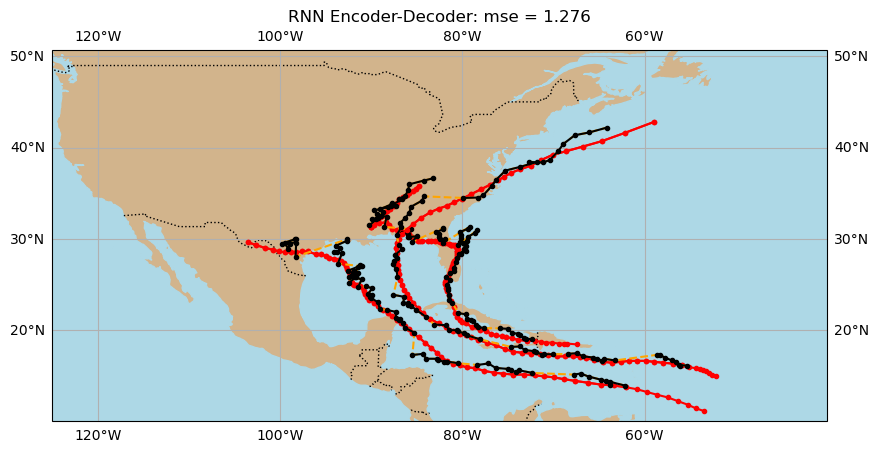

In [31]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 5
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_placeholders_vec(y_seq_length, (0,0))

X_val, y_val = pandas.DataFrame(), pandas.DataFrame()
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(df["LON"], df["LAT"])
    df_test.insert_placeholders_vec(y_seq_length, (0,0))
    X_val = pandas.concat([X_val, df_test.X.loc[range(8, len(df), y_seq_length)]])
    y_val = pandas.concat([y_val, df_test.y.loc[range(8, len(df), y_seq_length)]])

tsf_rnn = RNN_Vector_Forecaster(X_seq_length, y_seq_length, rnn_layers = [15], nn_layers = [2], activation = "linear", \
                                scalers = [("ab", {"a":-1, "b":1}), ("ab", {"a":-1, "b":1})], optimizer = ("Adam", {"lr":0.0001}), loss = "MSE", \
                                epochs = 31, batch_size = 50) 
tsf_rnn.fit(X_train = df_train.X, y_train = df_train.y, val_data = [X_val, y_val], pred_cols = [0,1]) 
tsf_rnns = RNNS_Vector_Forecaster(X_seq_length, y_seq_length, rnn_layers = [15], nn_layers = [2], activation = "linear", \
                                  scalers = tsf_rnn.scalers, weights = tsf_rnn.model.state_dict()) 

tsf_rnns_mse = 0 
for sid, df in hurrs_test.items(): 
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(df["LON"], df["LAT"])
    df_test.insert_placeholders_vec(y_seq_length, (0,0))
    tsf_rnns.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_rnns_mse += tsf_rnns.cv_results["mse_fold"].mean()
    tsf_rnns.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("RNN Encoder-Decoder: mse = {:.3f}".format(tsf_rnns_mse/3))
pyplot.show()

Now we'll try an **LSTM Encoder-Decoder**. Even worse! So far, the simple linear regression models are superior to the RNN, LSTM models. 

epoch: 0	training_loss: 0.0193	validation_loss: 0.00276
epoch: 1	training_loss: 0.00425	validation_loss: 0.00302
epoch: 2	training_loss: 0.00407	validation_loss: 0.00295
epoch: 3	training_loss: 0.00387	validation_loss: 0.00282
epoch: 4	training_loss: 0.00368	validation_loss: 0.00268
epoch: 5	training_loss: 0.0035	validation_loss: 0.00252
epoch: 6	training_loss: 0.00331	validation_loss: 0.00236
epoch: 7	training_loss: 0.0031	validation_loss: 0.0022
epoch: 8	training_loss: 0.00286	validation_loss: 0.00207
epoch: 9	training_loss: 0.0026	validation_loss: 0.00196
epoch: 10	training_loss: 0.00236	validation_loss: 0.00182
epoch: 11	training_loss: 0.00216	validation_loss: 0.00168
epoch: 12	training_loss: 0.00199	validation_loss: 0.00156
epoch: 13	training_loss: 0.00185	validation_loss: 0.00145
epoch: 14	training_loss: 0.00174	validation_loss: 0.00136
epoch: 15	training_loss: 0.00166	validation_loss: 0.00128
epoch: 16	training_loss: 0.00158	validation_loss: 0.00119
epoch: 17	training_loss: 0.00

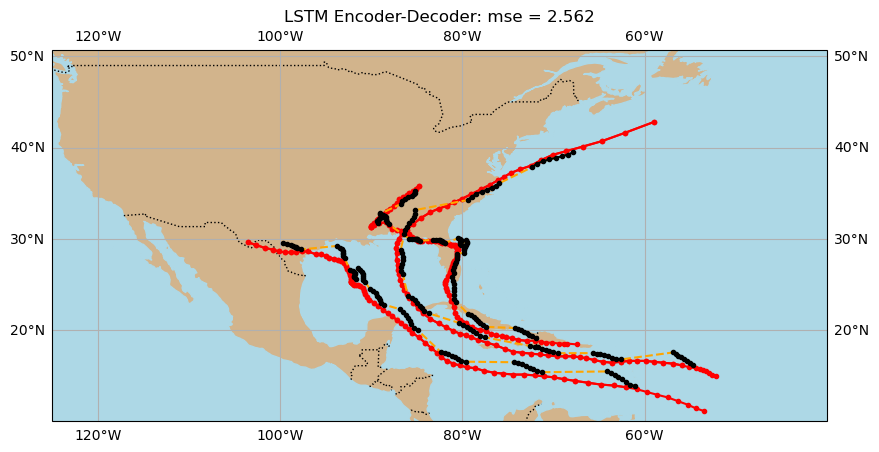

In [32]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 5
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_placeholders_vec(y_seq_length, (0,0))

X_val, y_val = pandas.DataFrame(), pandas.DataFrame()  # would use df.fit_vec_datasets, but need to restrict rows to precisely those of test hurricanes.
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(df["LON"], df["LAT"])
    df_test.insert_placeholders_vec(y_seq_length, (0,0))
    X_val = pandas.concat([X_val, df_test.X.loc[range(8, len(df), y_seq_length)]])
    y_val = pandas.concat([y_val, df_test.y.loc[range(8, len(df), y_seq_length)]])

tsf_lstm = LSTM_Vector_Forecaster(X_seq_length, y_seq_length, lstm_layers = [20], nn_layers = [2], activation = "linear", \
                                scalers = [("ab", {"a":-1, "b":1}), ("ab", {"a":-1, "b":1})], optimizer = ("Adam", {"lr":0.001}), loss = "MSE", \
                                epochs = 31, batch_size = 50) 
tsf_lstm.fit(X_train = df_train.X, y_train = df_train.y, val_data = [X_val, y_val], pred_cols = [0,1]) 
tsf_lstms = LSTMS_Vector_Forecaster(X_seq_length, y_seq_length, lstm_layers = [20], nn_layers = [2], activation = "linear", \
                                  scalers = tsf_lstm.scalers, weights = tsf_lstm.model.state_dict()) 

tsf_lstms_mse = 0 
for sid, df in hurrs_test.items(): 
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(df["LON"], df["LAT"])
    df_test.insert_placeholders_vec(y_seq_length, (0,0))
    tsf_lstms.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_lstms_mse += tsf_lstms.cv_results["mse_fold"].mean()
    tsf_lstms.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("LSTM Encoder-Decoder: mse = {:.3f}".format(tsf_lstms_mse/3))
pyplot.show()

#### Incorporating seasonal data: version A
One piece of information we haven't really been using is the time of the year the hurricane is present. The time of year is relevant because of periodic yearly weather patterns. Since the weather is a periodic variable, we could represent it as the sum of functions with at least yearly periodicity. We could say (where j is the day of the year): $w_j = \sum_{k=1}^{n}(a_k\cos(2\pi k j/365) + b_k\sin(2\pi kj/365)).$ In practice, we'll just keep a couple k's; I'll let n be the number kept (ultimately I'll choose n = 3, as that seems to yield the best results). So I'll have to add n columns to the dataframe. The columns will be the trig functions themselves - the ML algorithm will determine the best fit inverse Fourier transform coefficients $a_k$, and $b_k$. We'll start by going back to the original dataframe and adding these columns.

In [68]:
df_NASA = df_NA.copy()
n = 3
for k in range(1,n+1):
    df_NASA["sin_" + str(k)] = df_NASA["TIME"].apply(lambda x: numpy.sin(2*numpy.pi*k*x.dayofyear/365))
    df_NASA["cos_" + str(k)] = df_NASA["TIME"].apply(lambda x: numpy.cos(2*numpy.pi*k*x.dayofyear/365))
df_NASA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40179 entries, 2746 to 300565
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SID     40179 non-null  object        
 1   LAT     40179 non-null  float64       
 2   LON     40179 non-null  float64       
 3   TIME    40179 non-null  datetime64[ns]
 4   sin_1   40179 non-null  float64       
 5   cos_1   40179 non-null  float64       
 6   sin_2   40179 non-null  float64       
 7   cos_2   40179 non-null  float64       
 8   sin_3   40179 non-null  float64       
 9   cos_3   40179 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 3.4+ MB


And now we'll recreate the training and testing hurricane dictionaries.

In [69]:
hurrs = {}
for sid, group in df_NASA.groupby("SID"):
    hurrs[sid] = group
    hurrs[sid].drop("SID", axis=1, inplace = True)

SID_test = ["2003188N11307", "2008229N18293", "2000260N15308"]
hurrs_test = {sid: hurrs[sid] for sid in SID_test}

SID_train = [sid for sid in hurrs.keys() if sid not in SID_test]
hurrs_train = {sid: hurrs[sid] for sid in SID_train}

y_seq_length = 8

for sid in hurrs_train:
    hurrs_train[sid] = hurrs_train[sid][["LON", "LAT"] + ["sin_"+str(j) for j in range(1,n+1)]+["cos_"+str(j) for j in range(1,n+1)]]
    
for sid in hurrs_test:
    hurrs_test[sid] = hurrs_test[sid][["LON", "LAT"] + ["sin_"+str(j) for j in range(1,n+1)]+["cos_"+str(j) for j in range(1,n+1)]]
    last_index = int(y_seq_length*numpy.floor(len(hurrs_test[sid])/y_seq_length))
    hurrs_test[sid] = hurrs_test[sid].iloc[0:last_index]

And now we'll go back to the **RE_Vector_Forecaster** model. The model will predict $(x_{n+1}, y_{n+1}), ..., (x_{n+q}, y_{n+q})$ by doing multiple linear regression on all previous $(x_{n-p+1}, y_{n-p+1}), (x_{n-p+2}, y_{n-p+2}), ..., (x_n, y_n)$, as well as on the previous *p* and contemporaneous *q* $(\sin_1, \cos_1, \sin_2, \cos_2)$ terms. X_seq_length = 4, and alpha = 10 seem to be the best hyperparameters. And we do in fact get a better mse than the last RE_Vector model.

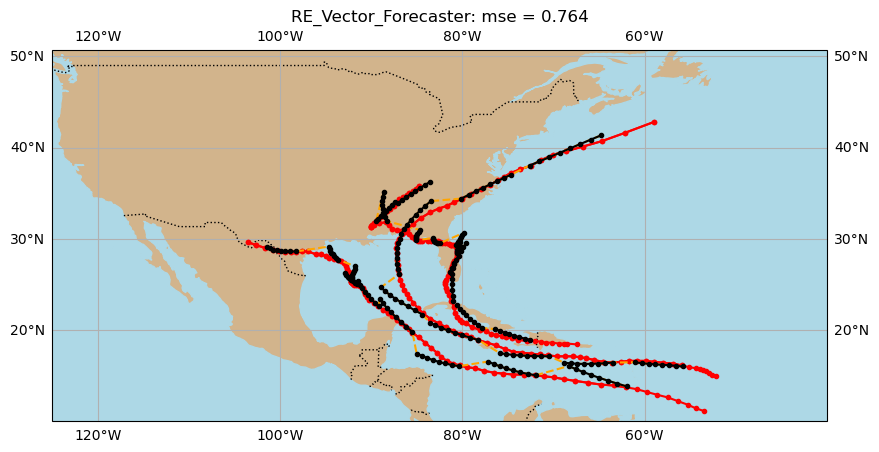

In [80]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 4
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_constant(tuple([1,0]+[0 for j in range(2*n)]))

tsf_rev = RE_Vector_Forecaster(X_seq_length, y_seq_length, alpha = 10)
tsf_rev.fit(X_train = df_train.X, y_train = df_train.y, pred_cols = [0,1])
tsf_revs = RES_Vector_Forecaster(X_seq_length, y_seq_length, coefs = tsf_rev.model.coef_, intercept = tsf_rev.model.intercept_)

tsf_revs_mse = 0
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(*[df[col] for col in df.columns])
    df_test.insert_constant(tuple([1,0]+[0 for j in range(2*n)]))
    tsf_revs.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_revs_mse += tsf_revs.cv_results["mse_fold"].mean()   
    tsf_revs.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("RE_Vector_Forecaster: mse = {:.3f}".format(tsf_revs_mse/3))
pyplot.show()

Let's do the same with a **DE_Vector Forecaster** model. The model will predict $(x_{n+1}, y_{n+1}), ..., (x_{n+q}, y_{n+q})$ by doing linear regression on the all the previous $(x_{n-p+1}, y_{n-p+1}), (x_{n-p+2}, y_{n-p+2}), ..., (x_n, y_n)$, as well as on the previous *p* and contemporaneous *q* $(\sin_1, \cos_1, \sin_2, \cos_2)$ terms to predict the first tuple $(x_{n+1, y_{n+1})$, and then recursively predict the rest. X_seq_length = 5, and alpha = 15 seem to be the best hyperparameters now. We get our lowest mse so far.

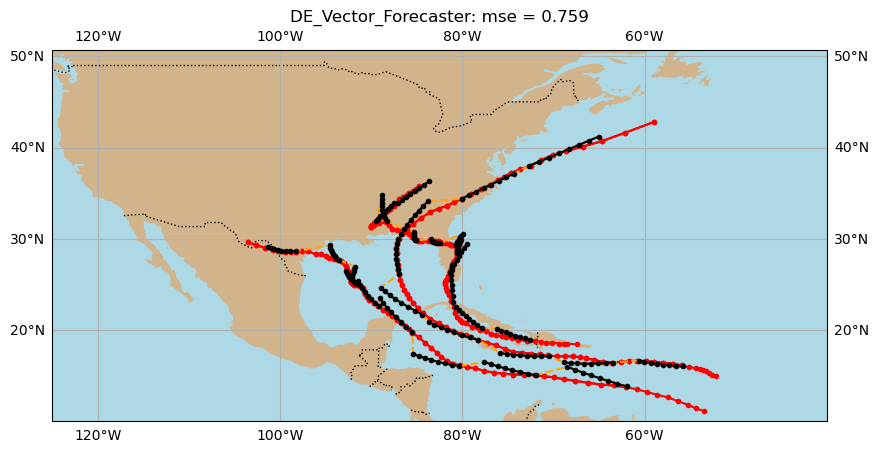

In [101]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 5
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_constant(tuple([1,0]+[0 for j in range(2*n)]))

tsf_dev = DE_Vector_Forecaster(X_seq_length, y_seq_length, alpha = 15)
tsf_dev.fit(X_train = df_train.X, y_train = df_train.y, pred_cols = [0,1])
tsf_devs = DES_Vector_Forecaster(X_seq_length, y_seq_length, coefs = tsf_dev.model.coef_)

tsf_devs_mse = 0
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(*[df[col] for col in df.columns])
    df_test.insert_constant(tuple([1,0]+[0 for j in range(2*n)]))
    tsf_devs.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])    
    tsf_devs_mse += tsf_devs.cv_results["mse_fold"].mean()   
    tsf_devs.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("DE_Vector_Forecaster: mse = {:.3f}".format(tsf_devs_mse/3))
pyplot.show()

Now we'll redo an **RNN Encoder-Decoder** with the extra seasonal variables and see if that helps. All features $(x_n, y_n, \sin_1, \cos_1, \sin_2, \cos_2, etc.)$ are fed into the encoder, whose hidden state is then passed to the decoder. The input to the decoder is $(0, 0, \sin_1, \cos_1, \sin_2, \cos_2, etc.)$, and the output is the predicted $(x_n,y_n)$. Does this help? Not really. Actually worse. I'm surprised that adding the extra features didn't help the RNN at all. 

epoch: 0	training_loss: 0.04806	validation_loss: 0.00625
epoch: 1	training_loss: 0.00645	validation_loss: 0.00301
epoch: 2	training_loss: 0.0042	validation_loss: 0.00254
epoch: 3	training_loss: 0.00319	validation_loss: 0.00156
epoch: 4	training_loss: 0.00264	validation_loss: 0.00174
epoch: 5	training_loss: 0.00232	validation_loss: 0.00115
epoch: 6	training_loss: 0.00212	validation_loss: 0.00114
epoch: 7	training_loss: 0.00193	validation_loss: 0.00109
epoch: 8	training_loss: 0.00179	validation_loss: 0.00092
epoch: 9	training_loss: 0.00167	validation_loss: 0.00072
epoch: 10	training_loss: 0.00158	validation_loss: 0.00088
epoch: 11	training_loss: 0.00151	validation_loss: 0.00055
epoch: 12	training_loss: 0.00144	validation_loss: 0.00072
epoch: 13	training_loss: 0.0014	validation_loss: 0.00084
epoch: 14	training_loss: 0.00134	validation_loss: 0.00086
epoch: 15	training_loss: 0.00131	validation_loss: 0.00115
epoch: 16	training_loss: 0.00128	validation_loss: 0.00067
epoch: 17	training_loss: 0

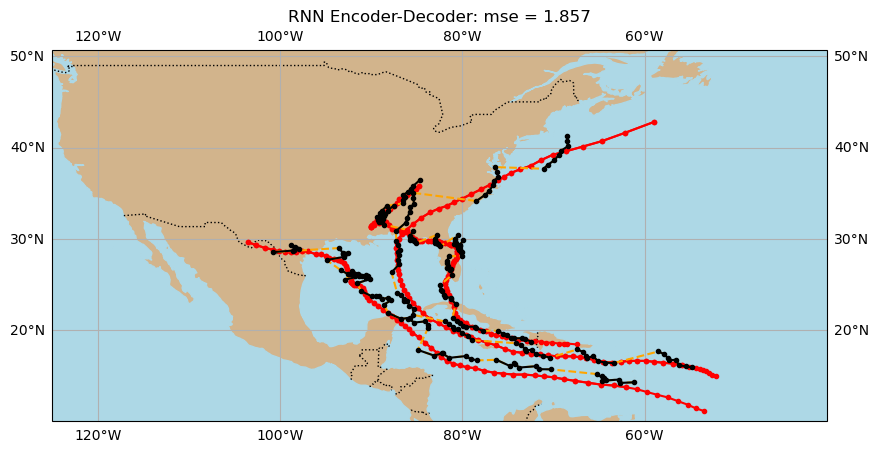

In [104]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 5
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.insert_placeholders_vec(y_seq_length, tuple([0,0]+["_" for j in range(2*n)]))

X_val, y_val = pandas.DataFrame(), pandas.DataFrame()
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(*[df[col] for col in df.columns])
    df_test.insert_placeholders_vec(y_seq_length, tuple([0,0]+["_" for j in range(2*n)]))
    X_val = pandas.concat([X_val, df_test.X.loc[range(8, len(df), y_seq_length)]])
    y_val = pandas.concat([y_val, df_test.y.loc[range(8, len(df), y_seq_length)]])

tsf_rnn = RNN_Vector_Forecaster(X_seq_length, y_seq_length, rnn_layers = [15], nn_layers = [2], activation = "linear", \
                                scalers = [("ab", {"a":-1, "b":1}), ("ab", {"a":-1, "b":1})] + [("unit",{}) for j in range(2*n)], \
                                optimizer = ("Adam", {"lr":0.001}), loss = "MSE", epochs = 31, batch_size = 50)
tsf_rnn.fit(X_train = df_train.X, y_train = df_train.y, val_data = [X_val, y_val], pred_cols = [0,1]) 
tsf_rnns = RNNS_Vector_Forecaster(X_seq_length, y_seq_length, rnn_layers = [15], nn_layers = [2], activation = "linear", \
                                  scalers = tsf_rnn.scalers, weights = tsf_rnn.model.state_dict()) 

tsf_rnns_mse = 0 
for sid, df in hurrs_test.items(): 
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(*[df[col] for col in df.columns])
    df_test.insert_placeholders_vec(y_seq_length, tuple([0,0]+["_" for j in range(2*n)]))
    tsf_rnns.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_rnns_mse += tsf_rnns.cv_results["mse_fold"].mean()
    tsf_rnns.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("RNN Encoder-Decoder: mse = {:.3f}".format(tsf_rnns_mse/3))
pyplot.show()

Let's try one more thing. Going back to the **RE_Vector_Forecaster** model, I'll add some features that mix the spatial coordinates of the hurricane with the Fourier components of the weather. I'll add columns consisting of the product of (LON, LAT) with $(\sin_1, \cos_1, \sin_2, \cos_2, etc.)$ (this is done via the df_train.expand() function). Retraining the RE_Vector model with these additional features reduces the mse further to about 0.71.

C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)
C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)
C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)
C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)


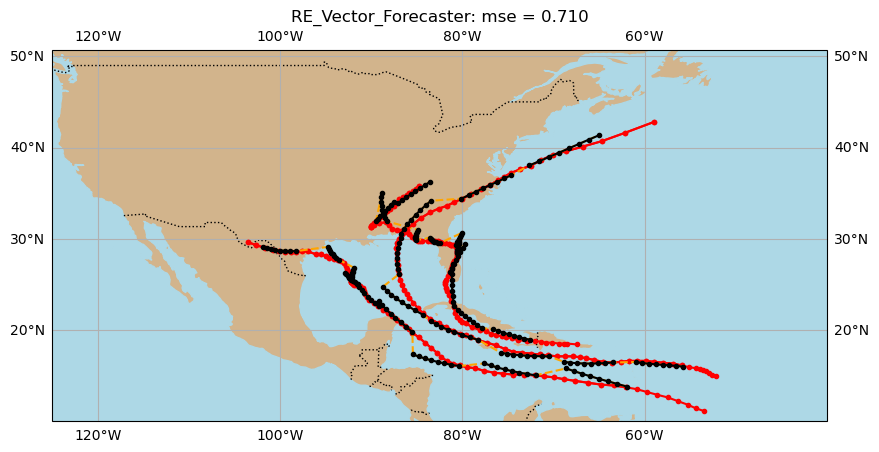

In [128]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 4
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.expand_X(expand = [0,1], hues = list(range(2,2*n+2)))
df_train.insert_constant(tuple([1,0]+[0 for j in range(2,2*n+2)]+2*[0 for j in range(2,2*n+2)]))

tsf_rev = RE_Vector_Forecaster(X_seq_length, y_seq_length, alpha = 25)
tsf_rev.fit(X_train = df_train.X, y_train = df_train.y, pred_cols = [0,1])
tsf_revs = RES_Vector_Forecaster(X_seq_length, y_seq_length, coefs = tsf_rev.model.coef_, intercept = tsf_rev.model.intercept_)

tsf_revs_mse = 0
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(*[df[col] for col in df.columns])
    df_test.expand_X(expand = [0,1], hues = list(range(2,2*n+2)))
    df_test.insert_constant(tuple([1,0]+[0 for j in range(2,2*n+2)]+2*[0 for j in range(2,2*n+2)]))
    tsf_revs.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_revs_mse += tsf_revs.cv_results["mse_fold"].mean()   
    tsf_revs.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("RE_Vector_Forecaster: mse = {:.3f}".format(tsf_revs_mse/3))
pyplot.show()

#### Incorporating seasonal data: version B
Last thing we'll try. Instead of using the Fourier weather components, we'll slice the 365 days of the year up into *r* bins, and classify the hurricanes according to the bin they fall into. Monthly bins would correspond to roughly *r = 12*, weekly bins to roughly *r = 52*. Looks like *r = 6* bins works best.

In [14]:
r = 6
df_NASB = df_NA.copy()
df_NASB["DAY"] = df_NA["TIME"].apply(lambda x: x.dayofyear)
df_NASB["BIN"] = pandas.cut(df_NASB.DAY, bins = r, labels = range(r))
df_NASB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40179 entries, 2746 to 300565
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SID     40179 non-null  object        
 1   LAT     40179 non-null  float64       
 2   LON     40179 non-null  float64       
 3   TIME    40179 non-null  datetime64[ns]
 4   DAY     40179 non-null  int64         
 5   BIN     40179 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.9+ MB


Let's see how many rows pertain to each bin. We can see that most of the tracked hurricanes are in the July-September range, naturally I guess.

In [15]:
df_NASB.groupby("BIN").size()

C:\Users\atdou\AppData\Local\Temp\ipykernel_3076\3935949847.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_NASB.groupby("BIN").size()


BIN
0      163
1      185
2     2488
3    12156
4    22205
5     2982
dtype: int64

Now I'll one-hot-encode the categorical BIN column. 

In [16]:
df_NASB = pandas.get_dummies(df_NASB, columns = ["BIN"], drop_first = True)
df_NASB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40179 entries, 2746 to 300565
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SID     40179 non-null  object        
 1   LAT     40179 non-null  float64       
 2   LON     40179 non-null  float64       
 3   TIME    40179 non-null  datetime64[ns]
 4   DAY     40179 non-null  int64         
 5   BIN_1   40179 non-null  bool          
 6   BIN_2   40179 non-null  bool          
 7   BIN_3   40179 non-null  bool          
 8   BIN_4   40179 non-null  bool          
 9   BIN_5   40179 non-null  bool          
dtypes: bool(5), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 2.0+ MB


Next we have to reset the training and testing dataframe dictionaries.

In [17]:
hurrs = {}
for sid, group in df_NASB.groupby("SID"):
    hurrs[sid] = group
    hurrs[sid].drop("SID", axis=1, inplace = True)

SID_test = ["2003188N11307", "2008229N18293", "2000260N15308"]
hurrs_test = {sid: hurrs[sid] for sid in SID_test}

SID_train = [sid for sid in hurrs.keys() if sid not in SID_test]
hurrs_train = {sid: hurrs[sid] for sid in SID_train}

y_seq_length = 8

for sid in hurrs_train:
    hurrs_train[sid] = hurrs_train[sid][["LON", "LAT"] + ["BIN_" + str(j) for j in range(1,r)]]
    
for sid in hurrs_test:
    hurrs_test[sid] = hurrs_test[sid][["LON", "LAT"] + ["BIN_" + str(j) for j in range(1,r)]]
    last_index = int(y_seq_length*numpy.floor(len(hurrs_test[sid])/y_seq_length))
    hurrs_test[sid] = hurrs_test[sid].iloc[0:last_index]

And now we'll go back to the **RE_Vector_Forecaster** model. The model will predict $(x_{n+1}, y_{n+1}), ..., (x_{n+q}, y_{n+q})$ by doing multiple linear regression on all previous $(x_{n-p+1}, y_{n-p+1}), (x_{n-p+2}, y_{n-p+2}), ..., (x_n, y_n)$. But we'll get a different regression according to the BIN value of the hurricane sequence. We get a good result, reflecting the value of accounting for seasonality in the trajectory. But it doesn't top our best model (mse = 0.71) which accounted for seasonality using Fourier components rather than bins. 

C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)
C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)
C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)
C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:319: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.X = self.X.applymap(f)


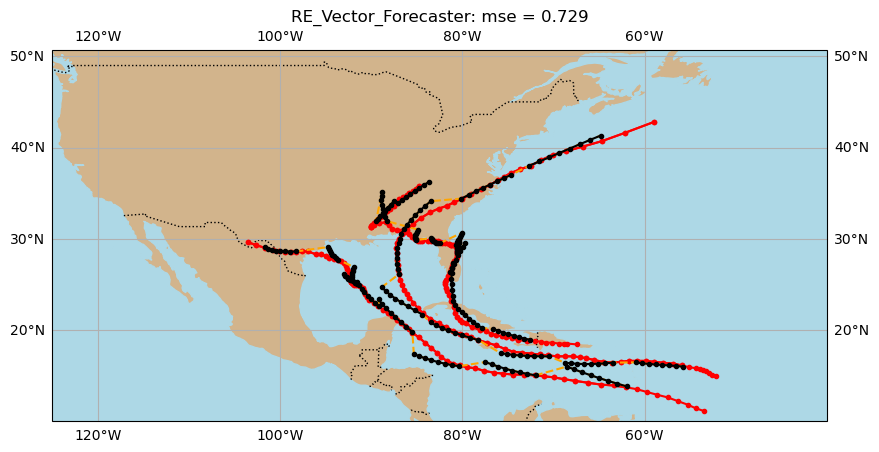

In [18]:
fig = pyplot.figure(figsize = (10,5)) 
ax = pyplot.axes(projection = ccrs.PlateCarree()) 
plot_test_hurricanes(ax)

X_seq_length = 4
df_train = create_dataframe(X_seq_length, y_seq_length)
df_train.fit_vec_datasets(hurrs_train)
df_train.expand_X(expand = [0,1], hues = [j for j in range(2,r+1)])
df_train.insert_constant(tuple([1,0]+[0 for j in range(2,r+1)]))

tsf_rev = RE_Vector_Forecaster(X_seq_length, y_seq_length, alpha = 10)
tsf_rev.fit(X_train = df_train.X, y_train = df_train.y, pred_cols = [0,1])
tsf_revs = RES_Vector_Forecaster(X_seq_length, y_seq_length, coefs = tsf_rev.model.coef_, intercept = tsf_rev.model.intercept_)

tsf_revs_mse = 0
for sid, df in hurrs_test.items():
    df_test = create_dataframe(X_seq_length, y_seq_length)
    df_test.fit_vec(*[df[col] for col in df.columns])
    df_test.expand_X(expand = [0,1], hues = [j for j in range(2,r+1)])
    df_test.insert_constant(tuple([1,0]+[0 for j in range(2,r+1)]))
    tsf_revs.cross_val(df_test.X, df_test.y, range(8, len(df), y_seq_length), pred_cols = [0,1])
    tsf_revs_mse += tsf_revs.cv_results["mse_fold"].mean()   
    tsf_revs.plot_targets_predictions_as_vectors(axes = ax)
pyplot.title("RE_Vector_Forecaster: mse = {:.3f}".format(tsf_revs_mse/3))
pyplot.show()

#### Conclusion
So overall, the linear models worked better than the RNN or LSTM Encoder-Decoder models. Just using LAT/LON positions, which should account for the effects of the Coriolis force, got us down to mse = 0.797. Feature engineering cyclical weather pattern effects using an inverse Fourier transform brought the mse down further roughly 10%, to mse = 0.71. 

#### 